# Welcome to GPyEm!

GPyEm is a package used to create independent multi-output emulators for cohort emulation studies using GPyTorch.

In this tutorial we will go through the basics of MCMC with GP emulators.

# Installation
## If you just want to use it...
```
pip install git+https://github.com/cwlanyon/GPyEm.git
```

## If you want to develop it...

Go to where you want to save your repo:
```
git clone https://github.com/cwlanyon/GPyEm.git
pip install -e GPyEm
```
So you can now import this in a python script anywhere you happen to be (no need to worry about paths etc):
```
from GPyEm import GPE_ensemble as GPE
```

## If you already have the repo on your computer...

Go to the location. E.g.
```
cd /home/me/Documents/code/GPyEm
```
Then call:
```
pip install -e .
```

In [25]:
# Import useful packages

import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal

# Import GPyEm
from GPyEm import GPE_ensemble as GPE

# Import packages for MCMC
import scipy

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize

from pyDOE import *

This tutorial gives a simple example of model calibration using the metropolis hastings algorith, the emcee python package and gaussian process emulators

As in Tutorial one we emulate (and then calibrate) the Branin function:
$$f(\theta) = a(\theta_2-b\theta_1^2+c\theta_1-r)^2+s(1-t)\cos(\theta_1)+s$$

With $a=1$, $b=5.1/(4*\pi**2)$, $c=5/\pi$, $r=6$, $s=10$, $t=1/(8*\pi)$.


The Branin function has three minima at $y^* = 0.397887$

In [13]:
def branin(xx, a=1, b=5.1/(4.0*np.pi**2), c=5.0/np.pi, r=6.0, s=10.0, t=1.0/(8.0*np.pi)): #Branin Function
    x1 = xx[0]
    x2 = xx[1]
    term1 = a * (x2 - b*x1**2 + c*x1 - r)**2
    term2 = s*(1-t)*np.cos(x1)
    y = term1 + term2 + s
    return(y)

In [14]:
rl = [-5,0] #lower observational bound
ru=[10,15] #upper observational bound

tp = 500 # number of test points

#x_test = torch.linspace(ru,rl,tp) #test points over full range


# Using our observational model we want to calibrate to $y^* = 0.397887$

In [15]:
#Define meshgrid over domain

X=np.linspace(rl[0],ru[0],100) 
Y=np.linspace(rl[1],ru[1],100)
XX,YY=np.meshgrid(X,Y)


In [16]:
Z=branin([XX,YY]) #Evaluate Branin on domain

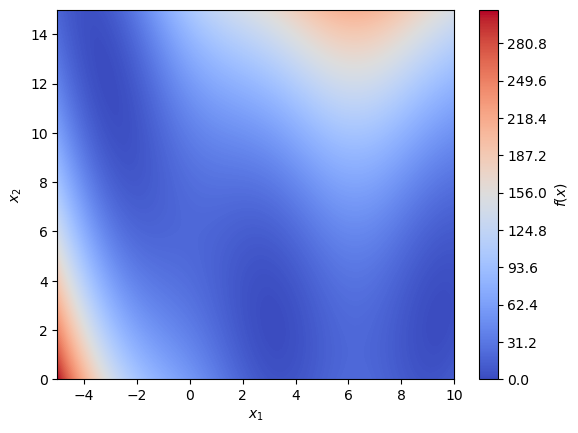

In [17]:
#Contour Plot of the Branin Function

plt.contourf(XX,YY,Z,origin='lower',levels=500,cmap=cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$f(x)$')


To illustrate the problem first we calibrate exactly. 

We will assume that the observation $y$ is subject to additive Gaussian error 
\begin{equation}
    y=f(x^*)+\epsilon
\end{equation}
with $\epsilon\sim N(0,\sigma_e)$, where $\sigma_e$ is some small (known) observational error.
The likelihood is then given by
\begin{equation}
    \pi(y|x^*) = \frac{1}{2\pi\sigma_e^2}\exp\left(-\frac{1}{2\sigma_e^2}(y-f(x^*))^2\right).
\end{equation}

We can calculate the posterior (up to a normalising constant) by multiplying the likelihood by the prior.

Below we show how the choice of prior and observation error affects the posterior.

In [21]:
# Generates 3 priors and 6 associated posteriors with 2 different observation errors

priors=[]
posterior_e1=[]
posterior_e2=[]
y_cal = 0.397887
prior_means=[[2.5,7.5],[8,2],[-5,10]] #3 prior mean locations
prior_sigmas2=[16,64,49] # 3 prior mean variances
e1=1 #Obs error 1
e2=0.1 #Obs error 2
 
for i in range(3):
    priors.append(scipy.stats.multivariate_normal.pdf(np.stack((XX,YY), axis=-1),prior_means[i],prior_sigmas2[i]*np.identity(2)))
    posterior_e1.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e1).reshape(Z.shape[0],Z.shape[1]))
    posterior_e2.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e2).reshape(Z.shape[0],Z.shape[1]))

In [22]:
lev=20 # levels of the contour plot

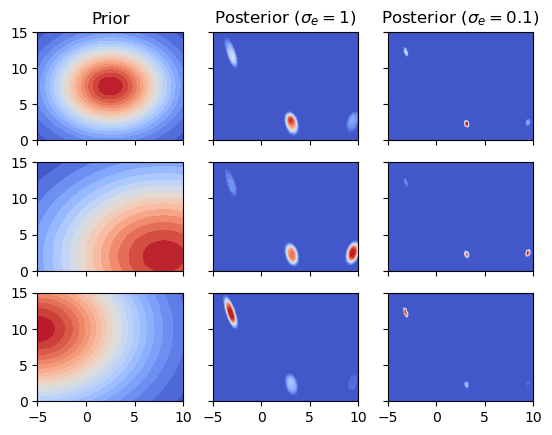

In [23]:
# Plots the three priors and 6 posteriors

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3)

ax1.set_title('Prior')
ax2.set_title('Posterior ($\sigma_e=$'+str(e1)+')')
ax3.set_title('Posterior ($\sigma_e=$'+str(e2)+')')

ax1.contourf(XX,YY,priors[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax2.contourf(XX,YY,posterior_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posterior_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)

ax4.contourf(XX,YY,priors[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax5.contourf(XX,YY,posterior_e1[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax6.contourf(XX,YY,posterior_e2[1],origin='lower',levels=lev,cmap=cm.coolwarm)

ax7.contourf(XX,YY,priors[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax8.contourf(XX,YY,posterior_e1[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax9.contourf(XX,YY,posterior_e2[2],origin='lower',levels=lev,cmap=cm.coolwarm)

for ax in fig.get_axes():
    ax.label_outer()


Next, we can perform the same analysis, but using an emulator. In this case the likelihood must take into account the emulator uncertainty, so becomes 

\begin{equation}
    \pi(y|x) = \frac{1}{\sqrt{2\pi(\sigma^2+k(x,x))}}\exp\left(-\frac{1}{2(\sigma^2+k(x,x))}(y-m(x))^2\right)
\end{equation}

where $\mu$ is the emulator mean function and $k$ is the emulator covariance. The log of this likelihood can be calculated directly from the GPyEm package, by calling the ''ensemble_log_likelihood_obs_error'' function.

Below we train two emulators with 100 and 10 training points, using maximin sampling to choose the training points

In [43]:
np.exp(emulator100.ensemble_log_likelihood_obs_error(torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2)),y_cal,[e1**2]).detach().numpy())

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [46]:
#Trains the two emulators, calculates posteriors, evaluates emulators over domain

np.random.seed(10)

posteriorE_e1=[]
posteriorE_e2=[]

y_cal=torch.tensor([y_cal])[:,None]

i=0 # Choose which prior from the above 3
p=100 #Number of training points

#X=np.random.uniform(rl[0],ru[0],p) #Training point locations
#Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

#x_train1=torch.tensor(np.array([X,Y])) #Training point locations

x_train1=torch.tensor(lhs(2,100,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)).T

y_train1 = branin(x_train1) #Observations (function evaluated at training points)

emulator100=GPE.ensemble(x_train1.T,y_train1[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e1.append(priors[i]*np.exp(emulator100.ensemble_log_likelihood_obs_error(torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2)),y_cal,[e1**2]).detach().numpy().reshape(100,100)))

Z100=emulator100.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator
p=10 #Number of training points

#X=np.random.uniform(rl[0],ru[0],p)
#Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

#x_train2=torch.tensor(np.array([X,Y]))

x_train2=torch.tensor(lhs(2,10,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)).T

y_train2 = branin(x_train2) #Observations (function evaluated at training points)
 

emulator10=GPE.ensemble(x_train2.T,y_train2[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e2.append(priors[i]*np.exp(emulator10.ensemble_log_likelihood_obs_error(torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2)),y_cal,[e1**2]).detach().numpy().reshape(100,100)))

Z10=emulator10.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator

0
0


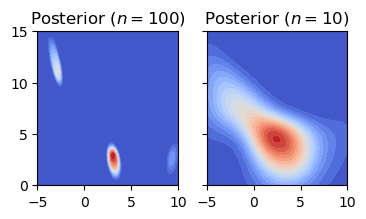

In [47]:
# Plots emulator priors and two posteriors
fig, ((ax2,ax3)) = plt.subplots(1, 2)


ax2.set_title('Posterior ($n=100$)')
ax3.set_title('Posterior ($n=10$)')


ax2.contourf(XX,YY,posteriorE_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posteriorE_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)




for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(4, 2)    

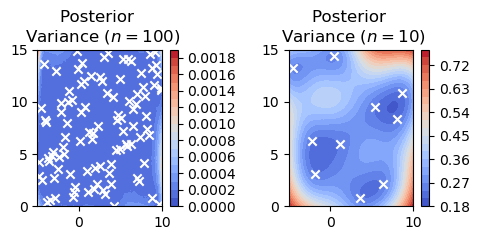

In [50]:
# Plots emulator priors and two posteriors
fig, ((ax2,ax3)) = plt.subplots(1, 2)


ax2.set_title('Posterior \n Variance ($n=100$)')
ax3.set_title('Posterior \n Variance ($n=10$)')


im1=ax2.contourf(XX,YY,k,origin='lower',levels=lev,cmap=cm.coolwarm)
im2=ax3.contourf(XX,YY,k2,origin='lower',levels=lev,cmap=cm.coolwarm)

ax2.scatter(x_train1[0],x_train1[1],c='w',marker='x')
ax3.scatter(x_train2[0],x_train2[1],c='w',marker='x')

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.96, top=0.94, wspace=0.4)
fig.colorbar(im1,ax=ax2, orientation='vertical')
fig.colorbar(im2,ax=ax3, orientation='vertical')

for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(5, 2.5)    
plt.tight_layout()


In [51]:
levs=np.linspace(-10,350,21) #Set levels for contour plots

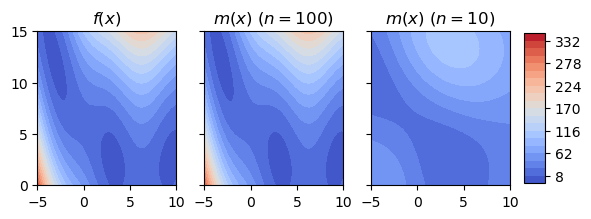

In [52]:
# Contour plots of the emulators
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$f(x)$')
ax2.set_title('$m(x)$ ($n=100$)')
ax3.set_title('$m(x)$ ($n=10$)')

ax1.contourf(XX,YY,Z,origin='lower',levels=levs,cmap=cm.coolwarm)
ax2.contourf(XX,YY,Z100,origin='lower',levels=levs,cmap=cm.coolwarm)
im=ax3.contourf(XX,YY,Z10,origin='lower',levels=levs,cmap=cm.coolwarm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.75])
fig.colorbar(im,cax=cbar_ax, orientation='vertical')


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      



# Calibrating with Metropolis hastings

## The metropolis hastings acceptance probability and algorithm

Here we calibrate with a simple metropolis hastings algorithm. For examples of how to use another package, such as emcee, see the workflow folder. 

In [61]:
def acceptance(y,x,x_prime,m1,m2,sigma2,sigmae2): # Log acceptance probabilty (for stability)
    ratio = (-(0.5/sigma2)*((x_prime[0]-m1)**2+(x_prime[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x_prime)-y)**2)-(-(0.5/sigma2)*((x[0]-m1)**2+(x[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x)-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [62]:
def metrop(y_cal,x0,m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters):
    chain = np.zeros((iters+1,2)) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.multivariate_normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,m1,m2,sigma2_prior,sigma2_e) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain



In [63]:
y=0.397887 # Calibration value for y
sigma2_mc =0.1*np.identity(2) # MCMC proposal variance
sigma2_e=1 # Observation error variance
sigma2_prior=16
iters=10000 # Number of MCMC iterations
m1=2.5
m2=7.5

In [64]:
X=[]
x0=[[11,4],[-1,9],[5,5]]
for i in range(3):
    X.append(metrop(y,x0[i],m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters))

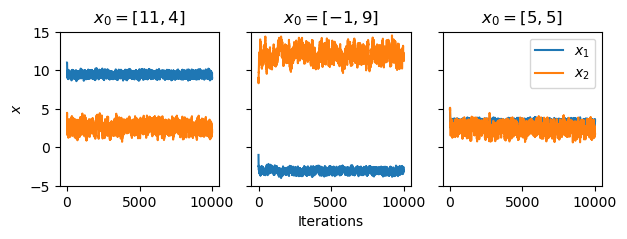

In [65]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$x_0=[11,4]$')
ax2.set_title('$x_0=[-1,9]$')
ax3.set_title('$x_0=[5,5]$')

ax1.plot(X[0])
ax1.set_ylim([-5, 15])
ax1.set_ylabel('$x$')
ax2.plot(X[1])
ax2.set_ylim([-5, 15])
ax2.set_xlabel('Iterations')
ax3.plot(X[2])
ax3.set_ylim([-5, 15])
ax3.legend(['$x_1$','$x_2$'])


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      



In [66]:
sigma2_mc =5*np.identity(2) # MCMC proposal variance
sigma2_e=10 # Observation error variance
sigma2_prior=16
iters=10000 # Number of MCMC iterations
m1=2.5
m2=7.5

In [67]:
X=[]
x0=[[11,4],[-1,9],[5,5]]
for i in range(3):
    X.append(metrop(y,x0[i],m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters))

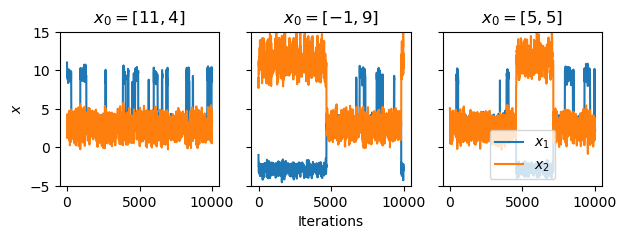

In [68]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$x_0=[11,4]$')
ax2.set_title('$x_0=[-1,9]$')
ax3.set_title('$x_0=[5,5]$')

ax1.plot(X[0])
ax1.set_ylim([-5, 15])
ax1.set_ylabel('$x$')
ax2.plot(X[1])
ax2.set_ylim([-5, 15])
ax2.set_xlabel('Iterations')
ax3.plot(X[2])
ax3.set_ylim([-5, 15])
ax3.legend(['$x_1$','$x_2$'],loc="lower center")


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      
